# CRAFT fine-tuning and inference interactive demo

This example notebook shows how to fine-tune a pretrained CRAFT conversational model for the task of forecasting conversational derailment, as shown in the "Trouble on the Horizon" paper (note however that due to nondeterminism in the training process, the results will not exactly reproduce the ones shown in the paper; if you need the exact inference results from the paper, see our [online demo](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH) that does inference only using the saved already-fine-tuned model from the paper).

Also note that this notebook is written primarily for the Wikipedia data. It will still work on the Reddit CMV data as well, but be aware that if seeking to compare results to those in the paper, the actual Reddit CMV evaluation contains some nuances that are not present in the Wikipedia data, as detailed in the [CMV version of the online demo](https://colab.research.google.com/drive/1aGBUBeiF3jT-GtBU9SDUoxhsjwKZaMKl?usp=sharing).

In [1]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import unicodedata
import itertools
from convokit import download, Corpus

# import all configuration variables
from model.config import *
# import data preprocessing functions
from model.data import *
# import our custom PyTorch modules
from model.model import *

%matplotlib inline

## Part 1: set up data preprocessing utilities

We begin by setting up some helper functions for preprocessing the ConvoKit Utterance data for use with CRAFT.

In [2]:
# Given a ConvoKit conversation, preprocess each utterance's text by tokenizing and truncating.
# Returns the processed dialog entry where text has been replaced with a list of
# tokens, each no longer than MAX_LENGTH - 1 (to leave space for the EOS token)
def processDialog(voc, dialog):
    processed = []
    for utterance in dialog.iter_utterances():
        # skip the section header, which does not contain conversational content
        if corpus_name == 'wikiconv' and utterance.meta['is_section_header']:
            continue
        tokens = tokenize(utterance.text)
        # replace out-of-vocabulary tokens
        for i in range(len(tokens)):
            if tokens[i] not in voc.word2index:
                tokens[i] = "UNK"
        processed.append({"tokens": tokens, "is_attack": int(utterance.meta[utt_label_metadata]) if utt_label_metadata is not None else 0, "id": utterance.id})
    if utt_label_metadata is None:
        # if the dataset does not come with utterance-level labels, we assume that (as in the case of CMV)
        # the only labels are conversation-level and that the actual toxic comment was not included in the
        # data. In that case, we must add a dummy comment containing no actual text, to get CRAFT to run on 
        # the context preceding the dummy (that is, the full prefix before the removed comment)
        processed.append({"tokens": ["UNK"], "is_attack": int(dialog.meta[label_metadata]), "id": processed[-1]["id"] + "_dummyreply"})
    return processed

# Load context-reply pairs from the Corpus, optionally filtering to only conversations
# from the specified split (train, val, or test).
# Each conversation, which has N comments (not including the section header) will
# get converted into N-1 comment-reply pairs, one pair for each reply 
# (the first comment does not reply to anything).
# Each comment-reply pair is a tuple consisting of the conversational context
# (that is, all comments prior to the reply), the reply itself, the label (that
# is, whether the reply contained a derailment event), and the comment ID of the
# last comment in the context (for later use in re-joining with the ConvoKit corpus).
# The function returns a list of such pairs.
def loadPairs(voc, corpus, split=None, last_only=False):
    pairs = []
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        if split is None or convo.meta['split'] == split:
            dialog = processDialog(voc, convo)
            iter_range = range(1, len(dialog)) if not last_only else [len(dialog)-1]
            for idx in iter_range:
                reply = dialog[idx]["tokens"][:(MAX_LENGTH-1)]
                label = dialog[idx]["is_attack"]
                # when re-joining with the corpus we want to store forecasts in
                # the last comment of each context (i.e. the comment directly
                # preceding the reply), so we must save that comment ID.
                comment_id = dialog[idx-1]["id"]
                # gather as context up to CONTEXT_SIZE utterances preceding the reply
                start = max(idx - CONTEXT_SIZE, 0)
                context = [u["tokens"][:(MAX_LENGTH-1)] for u in dialog[start:idx]]
                pairs.append((context, reply, label, comment_id))
    return pairs

## Part 2: load the data

Now we load the labeled corpus (Wikiconv or Reddit CMV) from ConvoKit, and run some transformations to prepare it for use with PyTorch

In [3]:
if corpus_name == "wikiconv":
    corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
elif corpus_name == "cmv":
    corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

Dataset already exists at /reef/convokit_corpora_jpc/conversations-gone-awry-corpus


In [4]:
# let's check some quick stats to verify that the corpus loaded correctly
print(len(corpus.get_utterance_ids()))
print(len(corpus.get_speaker_ids()))
print(len(corpus.get_conversation_ids()))

30021
8069
4188


In [5]:
# Let's also take a look at some example data to see what kinds of information/metadata are available to us
print(list(corpus.iter_conversations())[0].__dict__)
print(list(corpus.iter_utterances())[0])

{'obj_type': 'conversation', '_owner': <convokit.model.corpus.Corpus object at 0x7f012173f850>, '_id': '146743638.12652.12652', 'vectors': [], '_meta': ConvoKitMeta({'page_title': 'User talk:2005', 'page_id': 1003212, 'pair_id': '143890867.11926.11926', 'conversation_has_personal_attack': False, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'}), '_utterance_ids': ['146743638.12652.12652', '146743638.12667.12652', '146842219.12874.12874', '146860774.13072.13072'], '_speaker_ids': None, 'tree': None}
Utterance(id: '146743638.12652.12652', conversation_id: 146743638.12652.12652, reply-to: None, speaker: Speaker(id: 'Sirex98', vectors: [], meta: ConvoKitMeta({})), timestamp: 1185295934.0, text: '== [WIKI_LINK: WP:COMMONNAME] ==\n', vectors: [], meta: ConvoKitMeta({'is_section_header': True, 'comment_has_personal_attack': False, 'toxicity': 0, 'parsed': [{'rt': 3, 'toks': [{'tok': '=', 'tag': 'NFP', 'dep': 'punct', 'up': 3, 'dn': []}, {'tok': '=', 'tag':

Now we can use the utilities defined in Part 1 to convert the ConvoKit conversational data into a tokenized form that can be straightforwardly turned into Tensors later.

In [6]:
# First, we need to build the vocabulary so that we know how to map tokens to tensor indicies.
# For the sake of replicating the paper results, we will load the pre-computed vocabulary objects used in the paper.
voc = loadPrecomputedVoc(corpus_name, word2index_path, index2word_path)

In [7]:
# Inspect the Voc object to make sure it loaded correctly
print(voc.num_words) # expected vocab size is 50004: it was built using a fixed vocab size of 50k plus 4 spots for special tokens PAD, SOS, EOS, and UNK.
print(list(voc.word2index.items())[:10])
print(list(voc.index2word.items())[:10])

50004
[('UNK', 3), ('.', 4), ('the', 5), ("'", 6), (',', 7), ('to', 8), ('i', 9), ('of', 10), ('a', 11), ('and', 12)]
[('0', 'PAD'), ('1', 'SOS'), ('2', 'EOS'), ('3', 'UNK'), ('4', '.'), ('5', 'the'), ('6', "'"), ('7', ','), ('8', 'to'), ('9', 'i')]


In [8]:
# Convert the test set data into a list of input/label pairs. Each input will represent the conversation as a list of lists of tokens.
train_pairs = loadPairs(voc, corpus, "train", last_only=True)
val_pairs = loadPairs(voc, corpus, "val", last_only=True)
test_pairs = loadPairs(voc, corpus, "test")

In [9]:
# Validate the conversion by checking data size and some samples
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))
for p in train_pairs[:5]:
    print(p)

2508
840
4365
([['i', 'notice', 'that', 'UNK', 'that', 'moved', 'UNK', 'to', 'bill', 'chen', 'citing', 'UNK', ',', 'then', 'you', 'reverted', 'this', 'change', ',', 'bill', 'chen', 'doesn', "'", 't', 'commonly', 'go', 'by', 'william', ',', 'his', 'book', 'is', 'even', 'penned', 'as', 'bill', 'chen', '.', 'from', 'what', 'i', 'read', 'in', 'wp', ':', 'commonname', 'UNK', 'seems', 'to', 'be', 'correct', ',', 'examples', 'given', 'are', 'names', 'such', 'as', ':', '*', 'UNK', '(', 'not', 'UNK', ')', '*', 'UNK', '(', 'not', 'UNK', ')', 'i', 'think', 'this', 'revert', 'may', 'have', 'been', 'a'], ['chen', 'was', 'known', 'in', 'the', 'poker', 'world', 'as', '"', 'william', '"', 'for', 'years', 'before', 'he', 'became', 'commonly', 'known', 'as', '"', 'bill', '"', '.', 'i', 'changed', 'it', 'back', 'because', 'incidences', 'online', 'including', 'usenet', 'are', 'roughly', 'equal', ',', 'nothing', 'at', 'all', 'like', 'bill', 'clinton', 'and', 'william', 'clinton', ',', 'and', 'in', 'equal',

## Part 3: define the inference pipeline

CRAFT inference consists of three steps: (1) using the utterance encoder to produce embeddings of each comment in the context (2) running the comment embeddings through the context encoder to get a final representation of conversational context (3) running the classifier head on the context embedding. To streamline the subsequent code, we encapsulate these three steps in a single PyTorch `nn.Module`.

In [10]:
class Predictor(nn.Module):
    """This helper module encapsulates the CRAFT pipeline, defining the logic of passing an input through each consecutive sub-module."""
    def __init__(self, encoder, context_encoder, classifier):
        super(Predictor, self).__init__()
        self.encoder = encoder
        self.context_encoder = context_encoder
        self.classifier = classifier
        
    def forward(self, input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length):
        # Forward input through encoder model
        _, utt_encoder_hidden = self.encoder(input_batch, utt_lengths)
        
        # Convert utterance encoder final states to batched dialogs for use by context encoder
        context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
        
        # Forward pass through context encoder
        context_encoder_outputs, context_encoder_hidden = self.context_encoder(context_encoder_input, dialog_lengths)
        
        # Forward pass through classifier to get prediction logits
        logits = self.classifier(context_encoder_outputs, dialog_lengths)
        
        # Apply sigmoid activation
        predictions = F.sigmoid(logits)
        return predictions

## Part 4: define training loop

Now that we have all the model components defined, we need to define the actual training procedure. This will be a fairly standard neural network training loop, iterating over batches of labeled dialogs and computing cross-entropy loss on the predicted label. We will also define evaluation functions so that we can compute accuracy on the validation set after every epoch, allowing us to keep the model with the best validation performance. Note that for the sake of simpler code, validation accuracy is computed in the "unfair" manner using a single run of CRAFT over the full context preceding the actual personal attack, rather than the more realistic (and complicated) iterated evaluation that is used for final evaluation of the test set (in practice the two metrics track each other fairly well, making this a reasonable simplification for the sake of easy validation).

In [11]:
def train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
          encoder, context_encoder, attack_clf,                                                                    # network arguments
          encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
          batch_size, clip, max_length=MAX_LENGTH):                                                                # misc arguments

    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)
    
    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
    
    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths)
    
    # Calculate loss
    loss = F.binary_cross_entropy_with_logits(logits, labels)

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()

    return loss.item()

def evaluateBatch(encoder, context_encoder, predictor, voc, input_batch, dialog_lengths, 
                  dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, device, max_length=MAX_LENGTH):
    # Set device options
    input_batch = input_batch.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    # Predict future attack using predictor
    scores = predictor(input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length)
    predictions = (scores > 0.5).float()
    return predictions, scores

def validate(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    # containers for full prediction results so we can compute accuracy at the end
    all_preds = []
    all_labels = []
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)
        # aggregate results for computing accuracy at the end
        all_preds += [p.item() for p in predictions]
        all_labels += [l.item() for l in labels]
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    # compute and return the accuracy
    return (np.asarray(all_preds) == np.asarray(all_labels)).mean()

def trainIters(voc, pairs, val_pairs, encoder, context_encoder, attack_clf,
               encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
               n_iteration, batch_size, print_every, validate_every, clip):
    
    # create a batch iterator for training data
    batch_iterator = batchIterator(voc, pairs, batch_size)
    
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    # Training loop
    print("Training...")
    # keep track of best validation accuracy - only save when we have a model that beats the current best
    best_acc = 0
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch, training_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, _, target_variable, mask, max_target_len = training_batch
        dialog_lengths_list = [len(x) for x in training_dialogs]

        # Run a training iteration with batch
        loss = train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
                     encoder, context_encoder, attack_clf,                                                                    # network arguments
                     encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
                     true_batch_size, clip)                                                                                   # misc arguments
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Evaluate on validation set
        if (iteration % validate_every == 0):
            print("Validating!")
            # put the network components into evaluation mode
            encoder.eval()
            context_encoder.eval()
            attack_clf.eval()
            
            predictor = Predictor(encoder, context_encoder, attack_clf)
            accuracy = validate(val_pairs, encoder, context_encoder, predictor, voc, batch_size, device)
            print("Validation set accuracy: {:.2f}%".format(accuracy * 100))

            # keep track of our best model so far
            if accuracy > best_acc:
                print("Validation accuracy better than current best; saving model...")
                best_acc = accuracy
                torch.save({
                    'iteration': iteration,
                    'en': encoder.state_dict(),
                    'ctx': context_encoder.state_dict(),
                    'atk_clf': attack_clf.state_dict(),
                    'en_opt': encoder_optimizer.state_dict(),
                    'ctx_opt': context_encoder_optimizer.state_dict(),
                    'atk_clf_opt': attack_clf_optimizer.state_dict(),
                    'loss': loss,
                    'voc_dict': voc.__dict__,
                    'embedding': embedding.state_dict()
                }, os.path.join(save_dir, "finetuned_model.tar"))
            
            # put the network components back into training mode
            encoder.train()
            context_encoder.train()
            attack_clf.train()

## Part 5: define the evaluation procedure

We're almost ready to run! The last component we need is some code to evaluate performance on the test set after fine-tuning is completed. This evaluation should use the full iterative procedure described in the paper, replicating how a system might be deployed in practice, without knowledge of where the personal attack occurs

In [12]:
def evaluateDataset(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    output_df = {
        "id": [],
        "prediction": [],
        "score": []
    }
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)

        # format the output as a dataframe (which we can later re-join with the corpus)
        for i in range(true_batch_size):
            convo_id = convo_ids[i]
            pred = predictions[i].item()
            score = scores[i].item()
            output_df["id"].append(convo_id)
            output_df["prediction"].append(pred)
            output_df["score"].append(score)
                
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    return pd.DataFrame(output_df).set_index("id")

## Part 6: build and fine-tune the model

We finally have all the components we need! Now we can instantiate the CRAFT model components, load the pre-trained weights, and run fine-tuning.

In [13]:
# Fix random state (affect native Python code only, does not affect PyTorch and hence does not guarantee reproducibility)
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cuda')

print("Loading saved parameters...")
if not os.path.isfile(os.path.join(save_dir, "model.tar")):
    raise RuntimeError("Pretrained model not found. Have you run pretraining using train_generative_model.py?")
checkpoint = torch.load(os.path.join(save_dir, "model.tar"))
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Compute the number of training iterations we will need in order to achieve the number of epochs specified in the settings at the start of the notebook
n_iter_per_epoch = len(train_pairs) // batch_size + int(len(train_pairs) % batch_size == 1)
n_iteration = n_iter_per_epoch * finetune_epochs

# Put dropout layers in train mode
encoder.train()
context_encoder.train()
attack_clf.train()

# Initialize optimizers
print('Building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=labeled_learning_rate)
context_encoder_optimizer = optim.Adam(context_encoder.parameters(), lr=labeled_learning_rate)
attack_clf_optimizer = optim.Adam(attack_clf.parameters(), lr=labeled_learning_rate)

# Run training iterations, validating after every epoch
print("Starting Training!")
print("Will train for {} iterations".format(n_iteration))
trainIters(voc, train_pairs, val_pairs, encoder, context_encoder, attack_clf,
           encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
           n_iteration, batch_size, print_every, n_iter_per_epoch, clip)

Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 1170 iterations
Initializing ...
Training...
Iteration: 10; Percent complete: 0.9%; Average loss: 0.6940
Iteration: 20; Percent complete: 1.7%; Average loss: 0.6917
Iteration: 30; Percent complete: 2.6%; Average loss: 0.6923
Validating!
Iteration: 1; Percent complete: 7.1%
Iteration: 2; Percent complete: 14.3%
Iteration: 3; Percent complete: 21.4%
Iteration: 4; Percent complete: 28.6%
Iteration: 5; Percent complete: 35.7%
Iteration: 6; Percent complete: 42.9%
Iteration: 7; Percent complete: 50.0%
Iteration: 8; Percent complete: 57.1%
Iteration: 9; Percent complete: 64.3%
Iteration: 10; Percent complete: 71.4%
Iteration: 11; Percent complete: 78.6%
Iteration: 12; Percent complete: 85.7%
Iteration: 13; Percent complete: 92.9%
Iteration: 14; Percent complete: 100.0%
Validation set accuracy: 50.00%
Validation accuracy better than c

## Part 7: run test set evaluation

Now that we have successfully fine-tuned the model, we run it on the test set so that we can evaluate performance.

In [14]:
# Fix random state for reproducibility
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cuda')

print("Loading saved parameters...")
checkpoint = torch.load(os.path.join(save_dir, "finetuned_model.tar"))
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
attack_clf_sd = checkpoint['atk_clf']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
attack_clf.load_state_dict(attack_clf_sd)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Set dropout layers to eval mode
encoder.eval()
context_encoder.eval()
attack_clf.eval()

# Initialize the pipeline
predictor = Predictor(encoder, context_encoder, attack_clf)

# Run the pipeline!
forecasts_df = evaluateDataset(test_pairs, encoder, context_encoder, predictor, voc, batch_size, device)

Loading saved parameters...


Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 1.4%
Iteration: 2; Percent complete: 2.9%
Iteration: 3; Percent complete: 4.3%
Iteration: 4; Percent complete: 5.8%
Iteration: 5; Percent complete: 7.2%
Iteration: 6; Percent complete: 8.7%
Iteration: 7; Percent complete: 10.1%
Iteration: 8; Percent complete: 11.6%
Iteration: 9; Percent complete: 13.0%
Iteration: 10; Percent complete: 14.5%
Iteration: 11; Percent complete: 15.9%
Iteration: 12; Percent complete: 17.4%
Iteration: 13; Percent complete: 18.8%
Iteration: 14; Percent complete: 20.3%
Iteration: 15; Percent complete: 21.7%
Iteration: 16; Percent complete: 23.2%
Iteration: 17; Percent complete: 24.6%
Iteration: 18; Percent complete: 26.1%
Iteration: 19; Percent complete: 27.5%
Iteration: 20; Percent complete: 29.0%
Iteration: 21; Percent complete: 30.4%
Iteration: 22; Percent complete: 31.9%
Iteration: 23; Percent complete: 33.3%
Iteration: 24; Percent complete: 34.8%
Ite

In [15]:
# Inspect some of the outputs as a sanity-check
forecasts_df.head(20)

,prediction,score
id,,
191149920.17102.17102,1.0,0.535503
192892110.19259.19259,1.0,0.695249
190192199.17060.17060,0.0,0.408773
192890095.19227.19227,1.0,0.572100
190192005.17004.17004,0.0,0.311620
192885632.19156.19156,1.0,0.677030
190191827.16918.16918,0.0,0.173728
192882222.19129.19129,0.0,0.468783
190191097.16843.16843,0.0,0.250173


## Part 8: merge predictions back into corpus and evaluate

Now that the hard part is done, all that is left to do is to evaluate the predictions. Since the predictions are in no particular order, we will first merge each prediction back into the source corpus, and then evaluate each conversation according to the order of utterances within that conversation.

In [16]:
# We will add a metadata entry to each test-set utterance signifying whether, at the time
# that CRAFT saw the context *up to and including* that utterance, CRAFT forecasted the
# conversation would derail. Note that in datasets where the actual toxic comment is
# included (such as wikiconv), we explicitly do not show that comment to CRAFT (since
# that would be cheating!), so that comment will not have an associated forecast.
for convo in corpus.iter_conversations():
    # only consider test set conversations (we did not make predictions for the other ones)
    if convo.meta['split'] == "test":
        for utt in convo.iter_utterances():
            if utt.id in forecasts_df.index:
                utt.meta['forecast_score'] = forecasts_df.loc[utt.id].score

In [17]:
# Finally, we can use the forecast-annotated corpus to compute the forecast accuracy.
# Though we have an individual forecast per utterance, ground truth is at the conversation level:
# either a conversation derails or it does not. Thus, forecast accuracy is computed as follows:
#   - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
#   - False positives are cases that don't derail but for which the model made at least one positive forecast
#   - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
#   - True negatives are cases that don't derail, for which the model made no positive forecasts
# Note that in the included datasets (wikiconv and cmv), by construction, all forecasts we obtained are forecasts made prior to derailment
# (since these datasets end right before or right at the toxic comment). This simplifies  the computation of forecast metrics as we now 
# do not need to explicitly consider when a forecast was made. But if you are using a custom dataset where conversations continue past
# the toxic comment, you will need to take that into account when evaluating.

conversational_forecasts_df = {
    "convo_id": [],
    "label": [],
    "score": [],
    "prediction": []
}

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test":
        conversational_forecasts_df['convo_id'].append(convo.id)
        conversational_forecasts_df['label'].append(int(convo.meta[label_metadata]))
        forecast_scores = [utt.meta['forecast_score'] for utt in convo.iter_utterances() if 'forecast_score' in utt.meta]
        conversational_forecasts_df['score'] = np.max(forecast_scores)
        conversational_forecasts_df['prediction'].append(int(np.max(forecast_scores) > forecast_thresh))

conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
print((conversational_forecasts_df.label == conversational_forecasts_df.prediction).mean())

0.6440476190476191


In [18]:
# in addition to accuracy, we can also consider applying other metrics at the conversation level, such as precision/recall
def get_pr_stats(preds, labels):
    tp = ((labels==1)&(preds==1)).sum()
    fp = ((labels==0)&(preds==1)).sum()
    tn = ((labels==0)&(preds==0)).sum()
    fn = ((labels==1)&(preds==0)).sum()
    print("Precision = {0:.4f}, recall = {1:.4f}".format(tp / (tp + fp), tp / (tp + fn)))
    print("False positive rate =", fp / (fp + tn))
    print("F1 =", 2 / (((tp + fp) / tp) + ((tp + fn) / tp)))

get_pr_stats(conversational_forecasts_df.prediction, conversational_forecasts_df.label)

Precision = 0.6212, recall = 0.7381
False positive rate = 0.45
F1 = 0.674646354733406


## Part 9: model analysis: how early is early warning?

The goal of CRAFT is to forecast outcomes in advance, but how far in advance does it typically make its prediction? Following the paper, we measure this in two ways: the number of *comments* between the first prediction and the actual derailment, and how much *elapsed time* that gap actually translates to.

In [19]:
comments_until_derail = {} # store the "number of comments until derailment" metric for each conversation
time_until_derail = {} # store the "time until derailment" metric for each conversation

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test" and convo.meta[label_metadata]:
        # filter out the section header as usual
        utts = [utt for utt in convo.iter_utterances() if not (corpus_name == 'wikiconv' and utt.meta['is_section_header'])]
        if utt_label_metadata is not None:
            # if utterances have individual toxicity labels, we assume that the last comment in the conversation
            # is the one that is toxic (as in the case for wikiconv)
            derail_idx = len(utts) - 1
        else:
            # otherwise, we assume that the toxic comment is not included and that derailment happens immediately
            # after the last comment in the conversation
            derail_idx = len(utts)
        # now scan the utterances in order until we find the first derailment prediction (if any)
        for idx in range(1, len(utts)):
            if utts[idx].meta['forecast_score'] > forecast_thresh:
                comments_until_derail[convo.id] = derail_idx - idx
                time_until_derail[convo.id] = utts[derail_idx].timestamp - utts[idx].timestamp
                break

KeyError: 'forecast_score'

In [ ]:
# compute some quick statistics about the distribution of the "number of comments until derailment" metric
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
print(np.min(comments_until_derail_vals), np.max(comments_until_derail_vals), np.median(comments_until_derail_vals), np.mean(comments_until_derail_vals))

1 14 4.0 4.353876739562624


In [ ]:
# compute some quick statistics about the distribution of the "time until derailment" metric
# note that since timestamps are in seconds, we convert to hours by dividing by 3600, to make it more human readable
time_until_derail_vals = np.asarray(list(time_until_derail.values())) / 3600
print(np.min(time_until_derail_vals), np.max(time_until_derail_vals), np.median(time_until_derail_vals), np.mean(time_until_derail_vals))

0.009444444444444445 881.9655555555555 2.858888888888889 13.236288380826153


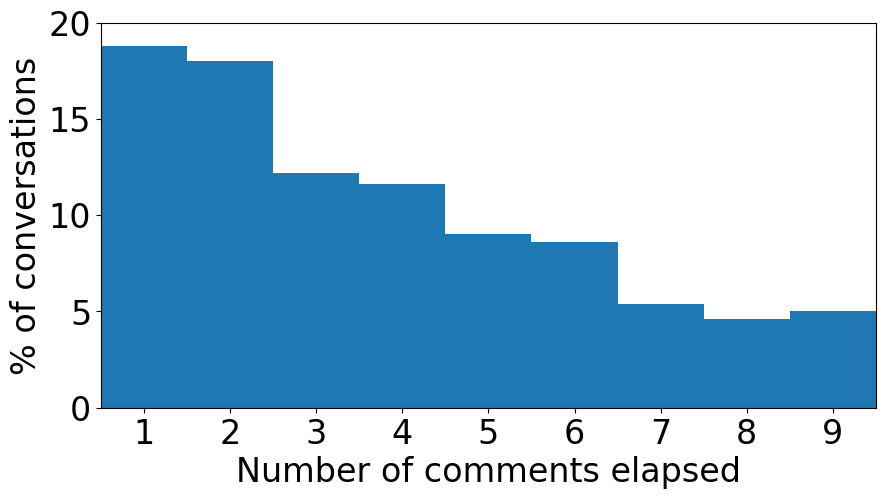

In [ ]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 24
plt.hist(comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True)
plt.xlim(1,10)
plt.xticks(np.arange(1,10)+0.5, np.arange(1,10))
plt.yticks(np.arange(0,0.25,0.05), np.arange(0,25,5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()